# Before you get started

## Data formatting

Ensure that your expression data is of the form log2(TPM+1) or log2(FPKM+1)

miner will search for specific filenames in the miner/data folder. In order to avoid "File does not exist" errors, do the following:
    1. Name your expression data "expressionData.csv"
    2. Name your mutation data "mutations.csv" (only for causal analysis)
    3. Name your survival data "survival.csv" (only for survival analysis)
   
Note that the gene names will be converted to Ensembl Gene ID format

## Input data requirements

The minimum input data required to run miner depends upon the type of output desired, as explained below. The current version of miner enables mechanistic inference based upon relational databases from homo sapiens. However, clustering by coexpression is not limited to homo sapiens data.

1. Cluster data by coexpression (without additional evidence of causation or mechanism)
    
    Required input: 
        1. expression data in .csv format with sample names as header and gene names as index   
    Output generated: 
        1. json dictionary with cluster labels as keys and genes belonging to the cluster
            -option to output samples where co-expression of cluster genes is significant (i.e., bicluster members)
        2. .csv file with cluster labels and ";"-separated list of genes and samples in cluster
            -option to output samples where co-expression of cluster genes is significant (i.e., bicluster members)
        3. heatmap of samples clustered according to their activity (low,medium,high,dysregulated) of each coexpressed cluster
    Special restrictions:
        1. expression data is pre-processed according to standard quality control for clustering
            a. if using gene expression, consider log2(expression+1)
            b. if using gene expression, correct for gene length
            c. if possible, provide data as log2(TPM+1)    
            
2. Cluster data by coregulation (coexpression + inference of regulators driving coexpression)
    
    Required input: 
        1. expression data in .csv format with sample names as header and gene names as index   
    Output generated: 
        1. json dictionary with cluster labels as keys and genes belonging to the cluster
            -option to output samples where co-expression of cluster genes is significant (i.e., bicluster members)
        2. .csv file with cluster labels and ";"-separated list of genes and samples in cluster
            -option to output samples where co-expression of cluster genes is significant (i.e., bicluster members)
        3. json dictionary with regulators and target genes that demonstrated significant mechanistic evidence for each coexpressed cluster
            -option to output .csv with target genes separated by ";" instead of .json
        4. json dictionary of regulons: regulators as keys with lists of target gene modules that they are inferred to regulate
        5. heatmap of samples clustered according to their activity (low,medium,high,dysregulated) of each coexpressed cluster 
        6. heatmap of samples clustered according to their activity (low,medium,high,dysregulated) of each regulon
        
    Special restrictions:
        1. expression data is pre-processed according to standard quality control for clustering
            a. if using gene expression, consider log2(expression+1)
            b. if using gene expression, correct for gene length
            c. if possible, provide data as log2(TPM+1)
        2. gene expression data is homo sapiens

3. Cluster data by coregulation and infer causal drivers (coexpression + inference of regulators driving coexpression + inference of upstream influences acting causally through the regulators to drive coexpression)
    
    Required input: 
        1. expression data in .csv or .txt format with sample names as header and gene names as index   
        2. mutation data as .csv file and formatted as described in special restrictions        
    Output generated: 
        1. json dictionary with cluster labels as keys and genes belonging to the cluster
            -option to output samples where co-expression of cluster genes is significant (i.e., bicluster members)
        2. .csv file with cluster labels and ";"-separated list of genes and samples in cluster
            -option to output samples where co-expression of cluster genes is significant (i.e., bicluster members)
        3. json dictionary with regulators and target genes that demonstrated significant mechanistic evidence for each coexpressed cluster
            -option to output .csv with target genes separated by ";" instead of .json
        4. json dictionary of regulons: regulators as keys with lists of target gene modules that they are inferred to regulate
        5. heatmap of samples clustered according to their activity (low,medium,high,dysregulated) of each coexpressed cluster 
        6. heatmap of samples clustered according to their activity (low,medium,high,dysregulated) of each regulon
        7. .csv file of cluster labels with associated regulators and mutations, including direction of interaction and p-value of inferred relationship (e.g., mutation up-regulates regulator, regulator represses cluster, etc.)
        
    Special restrictions:
        1. expression data is pre-processed according to standard quality control for clustering
            a. if using gene expression, consider log2(expression+1)
            b. if using gene expression, correct for gene length
            c. if possible, provide data as log2(TPM+1)  
        2. gene expression data is homo sapiens
        3. mutation file has samples as header, mutations (and/or other putative drivers) as index, and elements = 0 or 1
            a. element [i,j] = 1 if patient in row i has mutation in column j
            b. element [i,j] = 0 otherwise
        4. Causal inference will run in R, not python
            a. This tutorial will output the necessary inputs for the accompanying causal analysis notebook (causalTutorial)


## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin Tutorial

## Import standard dependencies

In [210]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.metrics import f1_score
import miner

## Create directory to save output files

In [1221]:
# create name for results folder where output files will be saved
resultsFolder = "results"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load input data

In [1332]:
# read gene expression into pandas dataframe
expressionData = pd.read_csv(os.path.join("..","data","IA12Zscore.csv"),index_col=0,header=0)
# convert gene names to Ensembl Gene ID
expressionData = miner.identifierConversion(expressionData)
# pre-process expressionData for optimized performance
expressionData = miner.zscore(expressionData)

completed identifier conversion.
16216 genes were converted.
completed z-transformation.


## Load previous results

In [1226]:
# If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"expandedGenesets.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulons = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
membershipDictionary = miner.read_json(os.path.join(resultsDirectory,"membershipDictionary.json"))

## 1. Cluster expression data

In [279]:
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes=8,overExpressionThreshold=80)
# sort cluster list from largest to smallest
initialClusters.sort(key= lambda s: -len(s))
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

0.00 percent complete
6.67 percent complete
13.33 percent complete
20.00 percent complete
26.67 percent complete
807 genes have been clustered.
33.33 percent complete
40.00 percent complete
46.67 percent complete
53.33 percent complete
60.00 percent complete
930 genes have been clustered.
66.67 percent complete
73.33 percent complete
80.00 percent complete
86.67 percent complete
93.33 percent complete
970 genes have been clustered.

coexpression clustering completed in 1.05 minutes


## Infer bicluster membership of revised clusters

In [1224]:
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label=2)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label=0)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(revisedClusters,bkgd,label="included")

done!


## Generate bicluster membership incidence matrices

In [ ]:
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
#dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
#coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

## Generate matrix of bicluster medians

In [1336]:
clusterMedianMatrix = miner.coexpressionMedianMatrix(expressionData,revisedClusters)
clusterMedianMatrix.head(5)

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
0,-0.013602,-0.075237,0.142625,0.779524,-0.574924,-0.100073,0.800408,-0.288158,0.685340,-0.201282,...,-0.093625,0.392904,-0.422813,0.472091,0.199363,0.366857,-0.075593,-0.020849,-0.634310,-0.296368
2,-0.079482,0.038040,0.036337,0.498840,-0.454581,0.272856,0.958139,-0.283501,0.776227,-0.131814,...,0.147924,0.299433,-0.361661,0.639028,-0.016913,0.306091,-0.007046,-0.036373,-0.630341,-0.115718
3,0.046720,0.211109,0.010426,0.358885,-0.314514,0.501738,1.141030,-0.179358,1.107049,-0.114415,...,0.285030,0.079817,-0.241789,0.746445,-0.101809,0.277196,-0.035609,-0.061366,-0.572328,-0.095169
4,0.115742,0.163837,-0.231312,0.809257,-0.421407,-0.121863,0.558284,-0.239004,0.454236,-0.387840,...,0.056425,0.202534,-0.369105,0.163171,-0.037930,0.433329,0.482576,-0.011783,-0.324249,-0.186407
5,0.606254,0.275757,-0.332122,0.415014,0.142097,0.164943,-0.201724,0.119802,-0.146843,-0.062763,...,0.277817,-0.381513,0.309042,-0.213370,-0.100484,0.547478,0.677333,-0.046291,0.118017,0.305695


## 2. Infer coregulated modules

In [233]:
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=5,freqThreshold = 0.333)
# write regulons to json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))


miner.py:901: RuntimeWarning: invalid value encountered in greater_equal
  


0
156
157
312
313
468
314
158
159
625
315
469
470
626
160
316
317
471
472
627
318
628
629
630
161
473
319
631
632
633
162
474
320
475
634
476
321
163
635
636
477
322
637
164
478
638
323
639
479
640
480
481
324
165
641
482
483
642
325
166
484
485
643
326
644
486
167
327
487
645
646
328
168
488
647
329
330
648
169
489
170
331
490
649
491
332
171
650
333
492
493
334
651
172
652
494
335
336
173
174
653
495
175
176
654
337
655
177
496
497
178
338
179
656
180
498
657
181
339
658
499
659
340
182
183
500
184
501
502
503
504
660
661
341
662
663
185
186
505
664
342
187
665
506
343
666
667
188
507
508
344
509
668
345
189
510
669
190
511
346
670
512
347
191
671
513
672
348
192
673
514
193
194
674
349
675
350
515
195
676
196
677
678
679
516
351
197
198
680
517
518
352
519
520
681
682
199
353
521
522
683
200
354
355
523
684
524
685
201
525
686
356
687
688
202
526
357
689
527
203
204
205
690
358
691
528
206
692
359
693
529
694
360
207
530
695
696
361
697
208
531
209
532
362
698
533
210
699
363
534
21

## Infer bicluster membership of coexpression modules

In [1227]:
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label=2)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label=0)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(coexpressionModules,bkgd,label="included")

done!
done!
done!
done!


## Generate bicluster membership incidence matrices

In [1228]:
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
#dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
#coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

In [1231]:
coexpressionMatrix = miner.coexpressionMedianMatrix(expressionData,coexpressionModules)
coexpressionMatrix.head(5)

,MMRF_1270_1_BM,MMRF_1037_1_BM,MMRF_2644_1_BM,MMRF_1235_1_BM,MMRF_1621_1_BM,MMRF_2313_1_BM,MMRF_1936_1_BM,MMRF_2006_1_BM,MMRF_2720_1_BM,MMRF_1654_1_BM,...,MMRF_2001_1_BM,MMRF_1295_1_BM,MMRF_2721_1_BM,MMRF_1296_1_BM,MMRF_2125_1_BM,MMRF_1374_1_BM,MMRF_2525_1_BM,MMRF_1307_1_BM,MMRF_1807_1_BM,MMRF_2082_1_BM
0,-0.033608,-0.039469,0.124968,0.770567,-0.597342,-0.110728,0.824197,-0.306955,0.654906,-0.244382,...,-0.126641,0.353571,-0.498699,0.459818,0.140895,0.349416,-0.105608,-0.062208,-0.645272,-0.298523
1,-0.067038,0.049441,-0.119256,0.244873,-0.337051,0.217096,0.626614,-0.234527,0.566974,-0.203591,...,0.142384,0.001749,-0.353925,0.448444,-0.235522,0.126490,-0.091635,-0.142103,-0.545210,-0.180311
2,0.140031,0.149388,-0.173100,0.798535,-0.403821,-0.111200,0.574363,-0.182659,0.498020,-0.386454,...,0.050600,0.224638,-0.381209,0.172700,-0.059186,0.416669,0.431557,0.003665,-0.284061,-0.150591
3,0.617807,0.375871,-0.339693,0.414243,0.118394,0.143428,-0.132089,0.088349,-0.229228,-0.049952,...,0.248423,-0.428306,0.257967,-0.243980,-0.125285,0.569227,0.676764,-0.027828,0.086502,0.366713
4,-0.145702,0.838217,-0.713724,0.350953,0.199303,0.516291,0.274542,0.112285,-0.091985,0.134493,...,0.802754,-0.356757,0.296382,0.600866,-0.668572,0.508105,0.418652,-0.493247,0.024335,0.453072


## Predict sample classes

In [1236]:
reload(miner)
sampleDictionary=overExpressedMembers
similarityClusters = miner.getSimilarityClusters(sampleDictionary,fequencyThreshold=0.333,similarityThreshold=0.15,highResolution=False)
highResolutionClusters, unclustered = miner.getSimilarityClusters(sampleDictionary,fequencyThreshold=0.333,similarityThreshold=0.15,highResolution=True)

done!
done!
done!
done!
done!
done!
done!
done!
done!


In [1238]:
intialClasses = miner.classesFromClusters(highResolutionClusters)

853


In [1271]:
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True)
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
plt.imshow(similarityMatrix.loc[np.hstack(initialClasses),np.hstack(initialClasses)],vmax=0.5)
#plt.savefig(os.path.join(resultsDirectory,"patientClasses15percent.pdf"))

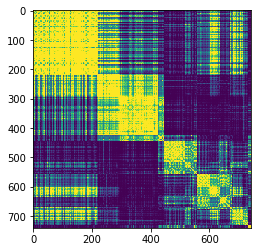

In [1272]:
centroidClusters, centroidMatrix = miner.centroids(initialClasses,sampleMatrix=overExpressedMembersMatrix,f1Threshold = 0.3,returnCentroids=True)
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
plt.imshow(similarityMatrix.loc[np.hstack(centroidClusters),np.hstack(centroidClusters)],vmin=0,vmax=0.55)

In [ ]:
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,overExpressedMembersMatrix,threshold = 0.25)

In [ ]:
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,overExpressedMembersMatrix,mappedClusters,resultsDirectory=resultsDirectory)